# Amplitude Modulation

## OOK Signal

In [1]:
# imports
import numpy as np

from commstools import set_backend
from commstools.channel import add_gaussian_noise
from commstools.filtering import rrc_taps
from commstools.plotting import filter_response, ideal_constellation
from commstools.waveforms import pam_waveform, rzpam_waveform

set_backend("gpu")


The On-Off Keying (OOK) signal is a simple amplitude modulation scheme where the carrier is present (high) when the bit is 1 and absent (low) when the bit is 0.

The constellation representation (here it is unipolar, but for OOK 0 will be at the origin):

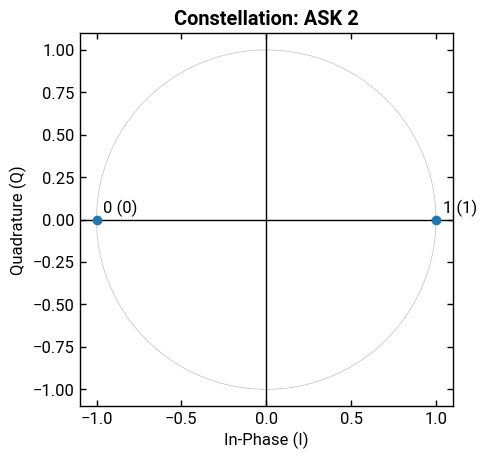

In [2]:
ideal_constellation(modulation="ask", order=2, show=True)


### RZ Scheme

Let's generate a waveform for so-called Return-to-Zero (RZ) encoding:

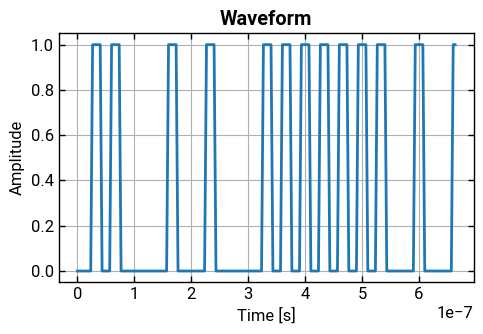

In [5]:
symbol_rate = 30e6
sampling_rate = 300e6
sps = int(sampling_rate / symbol_rate)

ook_rz_rect = rzpam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="rect",
    seed=42,
)

ook_rz_rect.plot_symbols(num_symbols=20, show=True)


Now the pulses represent perfect rectangles, which is not possible to generate with realistic equipment.

Also, such a waveform has very wide spectrum (see main lobe span):

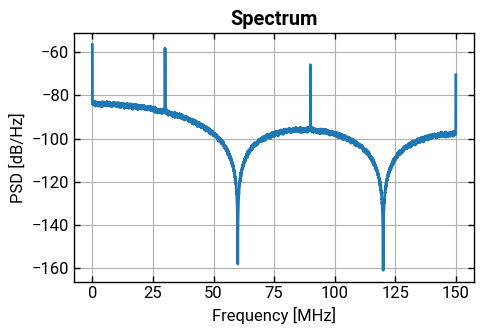

In [6]:
ook_rz_rect.plot_psd(show=True, nperseg=2**14)


To make waveform more practically realizable, we can pulse shape it to be gaussian-smoothed rectangular.

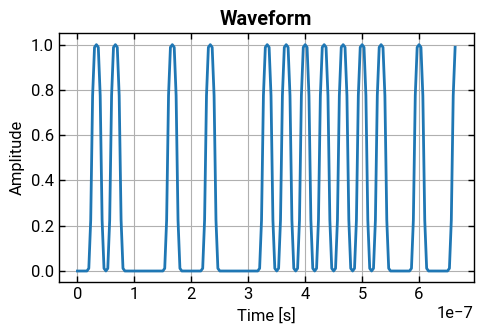

In [7]:
ook_rz_smoothrect = rzpam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="smoothrect",
    seed=42,
)
ook_rz_smoothrect.plot_symbols(num_symbols=20, show=True)


In this case, energy in the sidelobes is suppresed more:

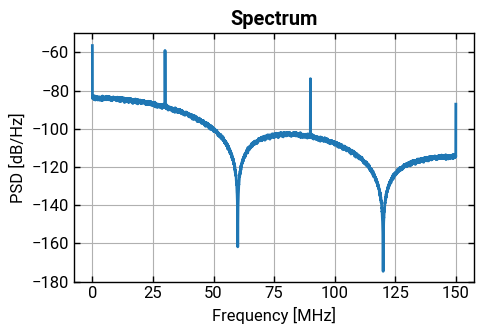

In [8]:
ook_rz_smoothrect.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


We also note that for RZ encoding, in the spectrum we have a strong tone at the symbol rate (repetition rate in this case) and its integer multiplies.
This is a useful property, called Self-Clocking, which lets receiver to lock onto this clock.

(For bipolar NRZ the clock can be recovered from the spectrum of signal squared.)

Let's look at the eye diagrams for this signal (preliminary adding some random noise for more realistic eye)

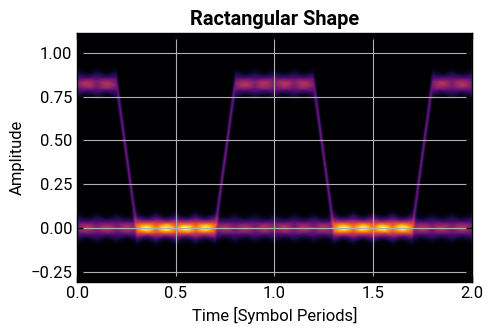

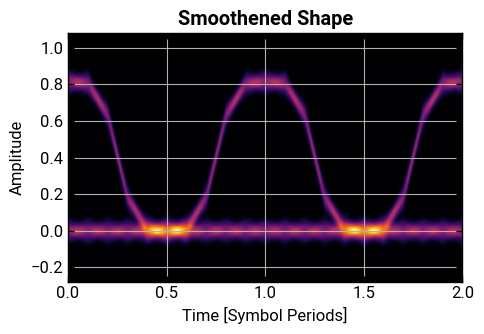

In [9]:
from commstools.channel import add_gaussian_noise

ook_rz_rect_n = add_gaussian_noise(ook_rz_rect, snr_db=20)
ook_rz_smoothrect_n = add_gaussian_noise(ook_rz_smoothrect, snr_db=20)

ook_rz_rect_n.plot_eye(title="Ractangular Shape", show=True)
ook_rz_smoothrect_n.plot_eye(title="Smoothened Shape", show=True)


### NRZ Scheme

The other encoding used with OOK is Non-Return-to-Zero (NRZ) - which requires half the bandwidth of RZ and is superior if system has bandwidth limitations.

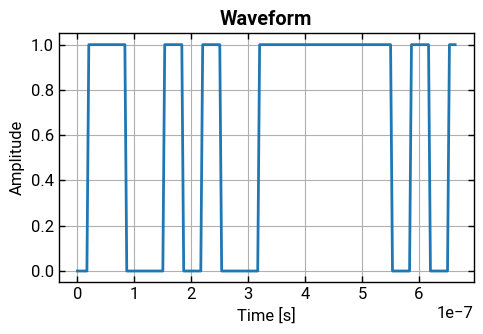

In [10]:
ook_nrz_rect = pam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="rect",
    seed=42,
)
ook_nrz_rect.plot_symbols(num_symbols=20, show=True)


The main lobe is twice as narrow, but doesn't contain the clock tone:

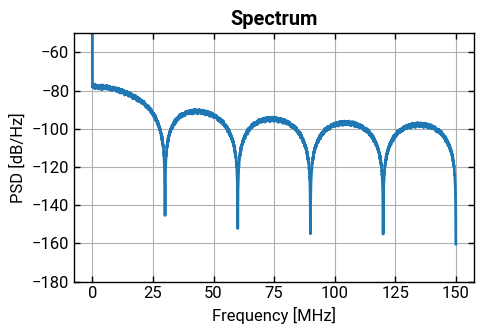

In [11]:
ook_nrz_rect.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


Let's also smooth the rect pulse.

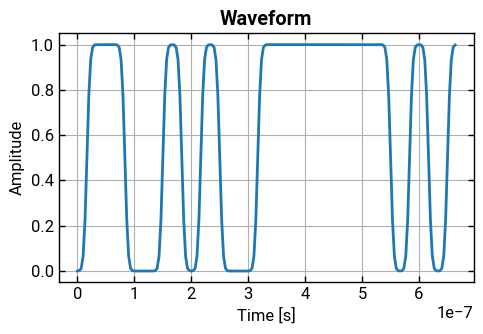

In [12]:
ook_nrz_smoothrect = pam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="smoothrect",
    seed=42,
)
ook_nrz_smoothrect.plot_symbols(num_symbols=20, show=True)


And see sidelobe energy reduction in the spectrum:

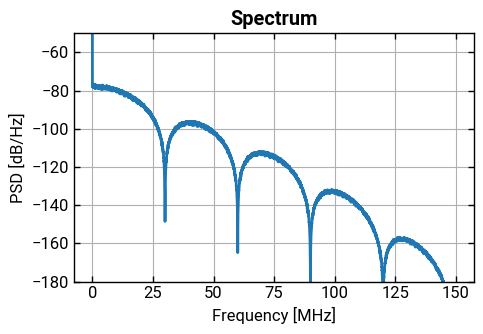

In [13]:
ook_nrz_smoothrect.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


Eye diagrams:

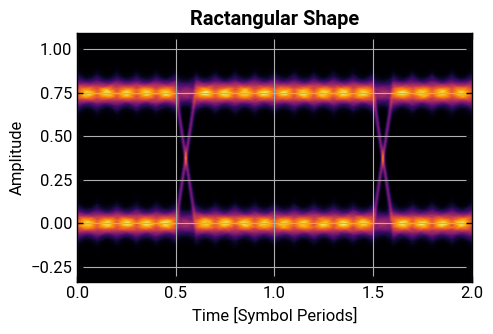

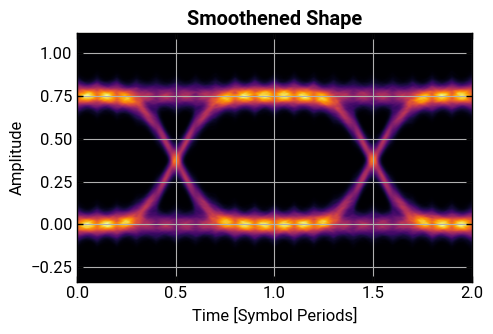

In [14]:
ook_nrz_rect_n = add_gaussian_noise(ook_nrz_rect, snr_db=20)
ook_nrz_smoothrect_n = add_gaussian_noise(ook_nrz_smoothrect, snr_db=20)

ook_nrz_rect_n.plot_eye(title="Ractangular Shape", show=True)
ook_nrz_smoothrect_n.plot_eye(title="Smoothened Shape", show=True)


## PAM Signal

Pulse-amplitude modulation (PAM) uses same concept, but usually assumed to be NRZ encoded and utilize multiple amplitude levels to represent more bits per symbolslot.
For instance, PAM-4 maps each amplitude level to 2 bits:

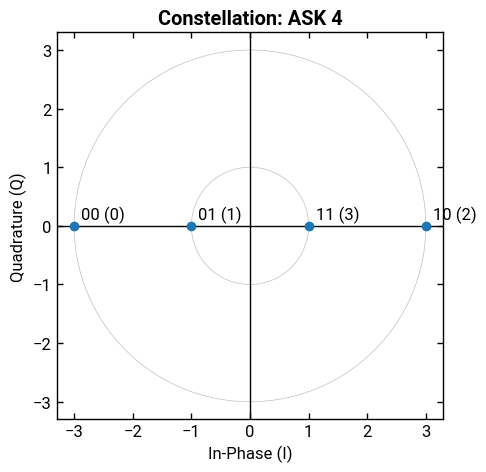

In [15]:
ideal_constellation(modulation="ask", order=4, show=True)


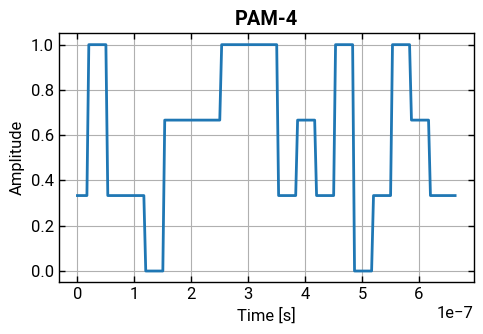

In [16]:
pam_waveform(
    order=4,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="rect",
    seed=42,
).plot_symbols(num_symbols=20, show=True, title="PAM-4")


Let's demonstrate this format using rrc pulse shape.

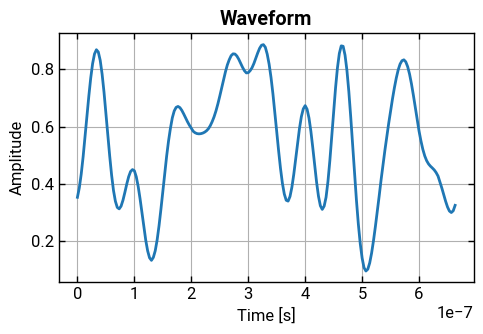

In [17]:
pam4 = pam_waveform(
    order=4,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="rrc",
    seed=42,
    filter_span=10,
)
pam4.plot_symbols(num_symbols=20, show=True)


The bandwidth of rrc-shaped signal is near-nyquist (relative to symbol rate) with some excess bandwidth from roll-off factor.

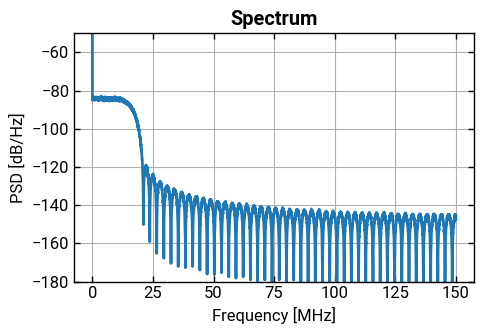

In [18]:
pam4.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


Let's generate the filter used for pulse shaping and check its response.

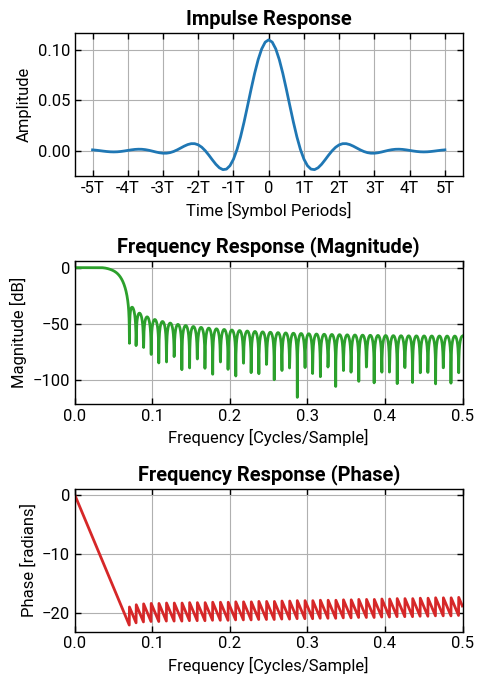

In [19]:
rrc_filter = rrc_taps(sps=sps, rolloff=0.35, span=10)
filter_response(rrc_filter, sps=sps, show=True)


Let's add some noise to the signal and see what happens to the symbols and spectrum.

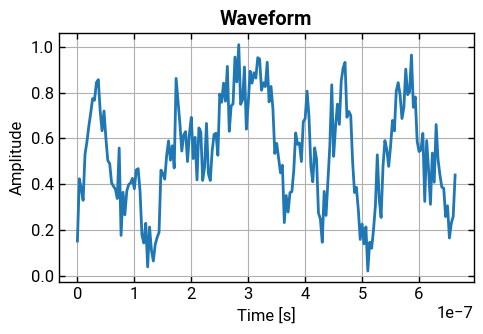

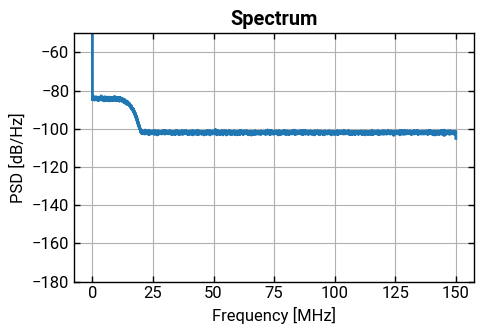

In [25]:
pam4_n = add_gaussian_noise(pam4, 15)
pam4_n.plot_symbols(num_symbols=20, show=True)
pam4_n.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


And now, let's matched filter the signal.

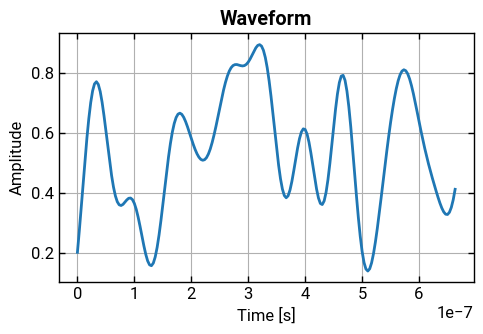

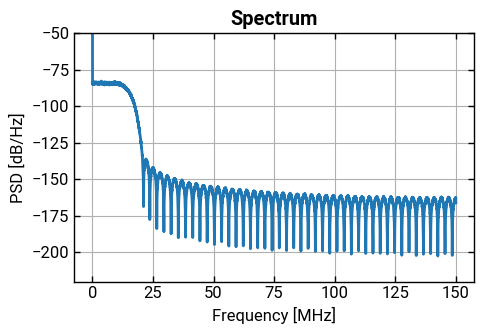

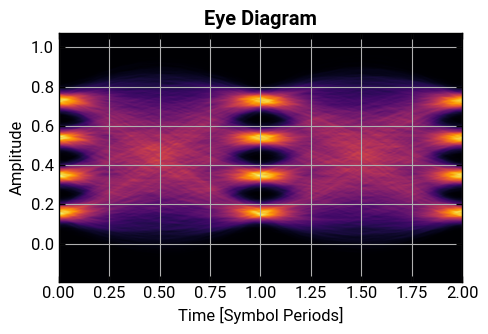

In [ ]:
pam4_n.matched_filter(pulse_taps=rrc_filter)
pam4_n.plot_symbols(num_symbols=20, show=True)
pam4_n.plot_psd(show=True, nperseg=2**14, ylim=(-220, -50))
pam4_n.plot_eye(show=True)
